<a href="https://colab.research.google.com/github/achrafbalij/Sentiment-Analysis-on-Financial-News/blob/main/SENTIMENT_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment Analysis on Financial Data**

### **1. Imports and Setups**

#### 1.0. Imports

In [1]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 33.2 MB/s 
     |████████████████████████████████| 163 kB 72.3 MB/s 
     |████████████████████████████████| 6.6 MB 53.7 MB/s 


In [2]:
import pandas as pd
import nltk
import re
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from collections import Counter, defaultdict

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,precision_score,accuracy_score,f1_score

from transformers import BertTokenizer,BertModel, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, pipeline, RobertaTokenizer

import warnings
warnings.filterwarnings('ignore')

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#### 1.1. Setting up GPU

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


### **2. Exploratory Data Analysis and Data Processing**

#### **2.1. Understanding the data**

For this project, we are going to use tha kaggle Dataset "FinancialPhraseBank", it containsthe sentiments for financial news headlines from the perspective of a retail investor.
Here is the link to the dataset: https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news

Our data contains 4846 observations and no missing values.

The data is partitioned into:
- Neutral: 59.41%
- Positive: 28.13%
- Negative: 12.46% 

In [4]:
url='https://raw.githubusercontent.com/achrafbalij/Sentiment-Analysis-on-Financial-News/main/all-data.csv?token=GHSAT0AAAAAABZWGVSHKG3MG4PPHQO54XFQY2BO7GA'
data=pd.read_csv(url, encoding="cp1252",header=None)
data.columns = ['sentiment', 'text']

HTTPError: ignored

In [ ]:
data

In [18]:
data.shape

(4846, 2)

In [21]:
data.isna().sum()

sentiment    0
text         0
dtype: int64

In [22]:
data.sentiment.value_counts()/data.shape[0]

neutral     0.594098
positive    0.281263
negative    0.124639
Name: sentiment, dtype: float64

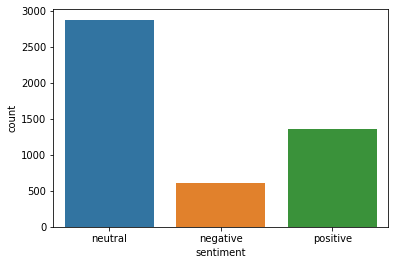

In [20]:
sns.countplot(x="sentiment", data=data)

#### **2.2. Pre-processing**
#### Data cleaning:
* Remove punctuation.
* Remove stop word.
* Normalize (by applying a Stemmer or a Lemmatizer ).
* Set all characters to lowercase.
* Remove numbers (or convert numbers to * textual representations).


In [24]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def cleaning_data(text):
  text = str(text).lower()
  text = text.replace('{html}', "")
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', text)
  rem_url=re.sub(r'http\S+', '',cleantext)
  rem_num = re.sub('[0-9]+', '', rem_url)
  tokenizer = RegexpTokenizer(r'\w+')
  tokens = tokenizer.tokenize(rem_num)  
  filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
  stem_words=[stemmer.stem(w) for w in filtered_words]
  lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
  return " ".join(filtered_words)
data['text']=data['text'].map(lambda s:cleaning_data(s)) 

#### **Wordcloud**

Wordcloud is a visual representation of words. It enable anyone to quickly identify and visualize patterns in sentiment data so that insights can be realized, communicated easily and shared among teams

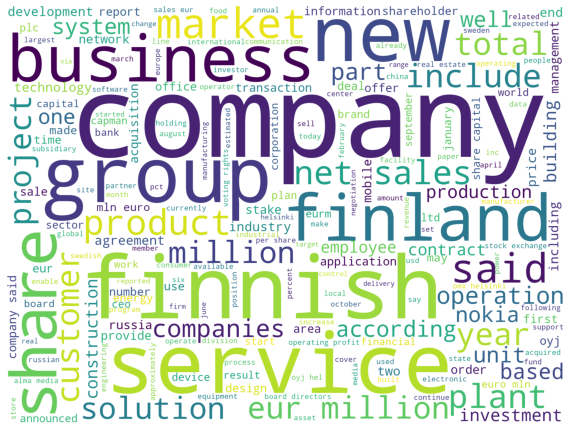

In [29]:
def plot_wordcloud(data):
  words = ' '.join(data['text'])
  no_urls_no_tags = " ".join([word for word in words.split()])

  wordcloud = WordCloud(stopwords=STOPWORDS,
                        background_color='white',
                        width=2000,
                        height=1500
                      ).generate(no_urls_no_tags)

  plt.figure(1,figsize=(10, 10))
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

plot_wordcloud(data[data['sentiment']=='neutral'])

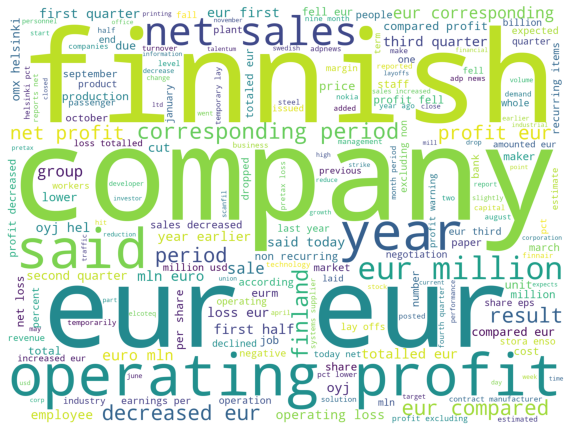

In [30]:
plot_wordcloud(data[data['sentiment']=='negative'])

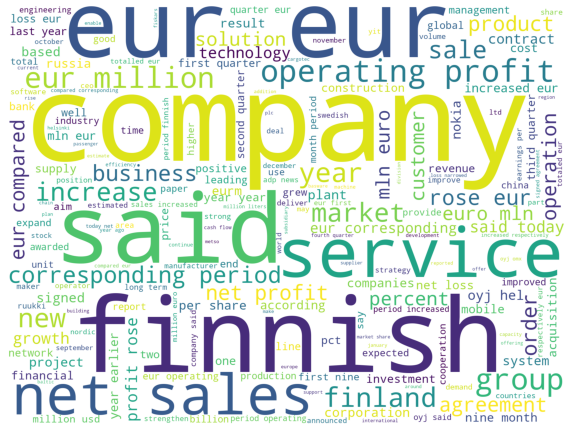

In [31]:
plot_wordcloud(data[data['sentiment']=='positive'])

#### **Word Frequencies**

In [ ]:
c_unique = Counter()
for ind in df.index:
    c_unique.update(Counter(set(df.loc[ind]['Tokens'])))

print('First 20 common words:\n')
for word in c_unique.most_common(20):
    print(word[0],'-->', 'appeared in',word[1],'documents out of {} documents i.e.'.format(len(df)),np.round(100*word[1]/len(df),2),'%')


First 20 common words:

company --> appeared in 801 documents out of 4846 documents i.e. 16.53 %
eur --> appeared in 801 documents out of 4846 documents i.e. 16.53 %
said --> appeared in 544 documents out of 4846 documents i.e. 11.23 %
finnish --> appeared in 512 documents out of 4846 documents i.e. 10.57 %
sales --> appeared in 428 documents out of 4846 documents i.e. 8.83 %
profit --> appeared in 406 documents out of 4846 documents i.e. 8.38 %
net --> appeared in 384 documents out of 4846 documents i.e. 7.92 %
year --> appeared in 341 documents out of 4846 documents i.e. 7.04 %
finland --> appeared in 331 documents out of 4846 documents i.e. 6.83 %
million --> appeared in 311 documents out of 4846 documents i.e. 6.42 %
group --> appeared in 305 documents out of 4846 documents i.e. 6.29 %
operating --> appeared in 294 documents out of 4846 documents i.e. 6.07 %
new --> appeared in 261 documents out of 4846 documents i.e. 5.39 %
business --> appeared in 251 documents out of 4846 docume

**Labeling the data**

In [ ]:
sent = data.sentiment.unique()
index = [i for i in range(len(sent.tolist()))]
label = dict(zip(sent, index))

sent = list(sent)
data['label'] = data.sentiment.replace(label)
data.head()

,sentiment,text,label
0,neutral,according gran company plans move production r...,0
1,neutral,technopolis plans develop stages area less squ...,0
2,negative,international electronic industry company elco...,1
3,positive,new production plant company would increase ca...,2
4,positive,according company updated strategy years baswa...,2


**Let's split the data now (70% train, 10% validation, 20% test)**

In [ ]:
df_temp, df_test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['sentiment'])
df_train, df_val = train_test_split(df_temp, test_size=0.1, random_state=42, stratify=df_temp['sentiment'])

In [ ]:
print("size of training set : " + str(df_train.shape[0]))
print("size of validation set : " + str(df_val.shape[0]))
print("size of test set : " + str(df_test.shape[0]))

size of training set : 3488
size of validation set : 388
size of test set : 970


Because the Data is imbalanced dataset, we will use oversampling as a mean to fix the imbalance but only on the training set.

In [ ]:
from sklearn.utils import resample

sentiment = data.sentiment.unique()
max = 2
target_majority = data[data.sentiment==sentiment[max]]


for cl in range(3):
    train_minority = df_train[df_train.sentiment==sentiment[cl]]
    train_minority_upsampled = resample(train_minority, replace=True, n_samples=len(target_majority), random_state=33)
    if cl == 0:
        train_upsampled = pd.concat([train_minority_upsampled, target_majority])
        #train_upsampled = pd.concat([train_upsampled, ])
    if cl>0 and cl!=max:
        train_upsampled = pd.concat([train_minority_upsampled, train_upsampled])

train_upsampled['sentiment'].value_counts() 

negative    1363
neutral     1363
positive    1363
Name: sentiment, dtype: int64

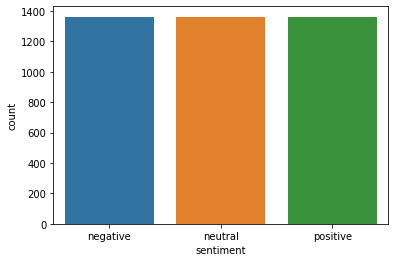

In [ ]:
sns.countplot(x="sentiment", data=train_upsampled)

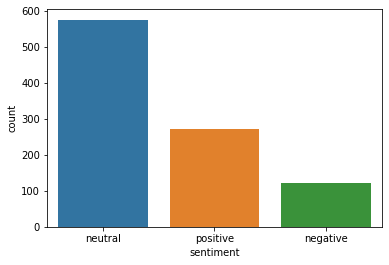

In [ ]:
sns.countplot(x="sentiment", data=df_test)

### **3. Classification model**

**3.1. Baseline: TF-IDF And Naive Bayes Classifier**

TF-IDF Vectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train_text = np.array(train_upsampled['text'])
X_val_text = np.array(df_val['text'])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=False,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_text)
X_val_tfidf = tf_idf.transform(X_val_text)

Train Naive Bayes Classifier

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):

    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    auc = cross_val_score(model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

In [ ]:
from sklearn.naive_bayes import MultinomialNB

res = pd.Series([get_auc_CV(MultinomialNB(i)) for i in np.arange(1, 10, 0.1)],
                index=np.arange(1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

TypeError: ignored

In [ ]:
get_auc_CV(MultinomialNB())

NameError: ignored

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
model = MultinomialNB()
model.fit(X_train_tfidf, train_upsampled['label'])

MultinomialNB()

In [ ]:
model.score(X_val_tfidf, df_val['label'])

0.7474226804123711

In [ ]:
##################

### **BERT**

In [ ]:
model = BertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=3)
tokenizer = BertTokenizer.from_pretrained("distilbert-base-uncased")

Dataset

In [ ]:
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

dataset_train = dataset_train.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_val = dataset_val.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_test = dataset_test.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length' , max_length=128), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy' : accuracy_score(predictions, labels)}

In [ ]:
args = TrainingArguments(
        output_dir = 'temp/',
        evaluation_strategy="steps",
        num_train_epochs=5,              
        per_device_train_batch_size=32,  
        per_device_eval_batch_size=64,   
        warmup_steps=500,                
        weight_decay=0.01,               
        logging_dir='./logs4',            
        #logging_steps=10,
        load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
        model=model,                         
        args=args,                  
        train_dataset=dataset_train,         
        eval_dataset=dataset_val,           
        compute_metrics=compute_metrics
)

trainer.train() 

In [ ]:
model.eval()
trainer.predict(dataset_test).metrics

In [ ]:
preds = trainer.predict(dataset_test)

In [ ]:
probs = torch.from_numpy(preds[0]).softmax(1)
predictions = probs.numpy()# convert tensors to numpy array

new_df = pd.DataFrame(predictions,columns=data.sentiment.unique())
new_df.head()

In [ ]:
def labels(x):
  if x == 0:
    return 'neutral'
  elif x == 1:
    return 'negative'
  else:
    return 'positive'

results = np.argmax(predictions,axis=1)
df_test['Sentiment'] = results
df_test['Sentiment'] = df_test['Sentiment'].map(labels)

df_test['pred_label'] = results

df_test['Org_Sentiment'] = df_test['label'].map(labels)
df_test.head()

In [ ]:
print(classification_report(df_test['label'], df_test['pred_label']))

FinBERT